In [1]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from src.utils import *

In [2]:
mpl.rcParams['font.size'] = 10
json_file_path = './../data/results_weights.json'
results_file_path = './../data/results_by_dataset_model_xai.csv'
datasets = ['QoS-QoE', 'UNAC', '5G Slicing']
xai_pairs = ['PI SHAP', 'PI LIME', 'SHAP LIME']
    
def plot_consistency_regarding_datasets():
    for result_name, result_dataframe in divide_dataframe_regarding_mcc(pd.read_csv(results_file_path)).items():
            
        dataset_values = []
        models_values = []
        xai_values = []
        correlation_values = []
    
        result = generate_correlation_matrices(json_file_path, 'TE')
        for dataset in datasets:
            models_in_dataset = result_dataframe[result_dataframe['Dataset'] == dataset]['Model'].unique().tolist()
            for model in models_in_dataset:
                corr_matrix_as_df = result[dataset][model]
    
                for col_name in corr_matrix_as_df.columns:
                    for row_name in corr_matrix_as_df.index:
                        cell_value = corr_matrix_as_df.loc[row_name, col_name]
                        if col_name != row_name and f'{col_name} {row_name}' in xai_pairs:
    
                            dataset_values += [dataset]
                            models_values += [model]
                            xai_values += [f'{col_name} {row_name}']
                            correlation_values += [cell_value]
    
        xs = [datasets.index(v) for v in dataset_values]
        ys = [xai_pairs.index(v) for v in xai_values]
        zs = correlation_values
    
        aux_pi = []
        aux_shap = []
        aux_lime = []
    
        for i in range(len(xs)):
    
            if "PI" in xai_values[i]:
                aux_pi += [zs[i]]
            if "SHAP" in xai_values[i]:
                aux_shap += [zs[i]]
            if "LIME" in xai_values[i]:
                aux_lime += [zs[i]]
    
    
        # ////// transforming the data to avg and stv for the v2 \\\\\\\
        from collections import defaultdict
        data = defaultdict(list)
        # Iterate over the data and collect z values for each (x, y) pair
        for xi, yi, zi in zip(xs, ys, zs):
            data[(xi, yi)].append(zi)
        averages = {key: np.average(vals) for key, vals in data.items()}
        std_dev = {key: np.std(vals) for key, vals in data.items()}
    
        # Separate the averaged values back into x, y, and z lists
        xs = [xi for xi, _ in averages]
        ys = [yi for _, yi in averages]
        zs = [averages[(xi, yi)] for xi, yi in averages]
        zs_std_p = [averages[(xi, yi)] + std_dev[(xi, yi)] for xi, yi in std_dev]
        zs_std_n = [averages[(xi, yi)] - std_dev[(xi, yi)] for xi, yi in std_dev]
    
        # \\\\\\\ transforming the data to avg and stv for the v2 //////
    
        fig = plt.figure(figsize=(16, 6))
        ax = fig.add_subplot(111, projection='3d')
    
        # surface 1
        X, Y = np.meshgrid(np.linspace(min(xs), max(xs), 100), np.linspace(min(ys), max(ys), 100))
        Z = griddata((xs, ys), zs, (X, Y), method='linear')
        surf = ax.plot_surface(X, Y, Z, cmap="Blues", linewidth=1, antialiased=False, alpha=0.9, vmin=-1, vmax=1)
    
        # surface 2
        Z2 = griddata((xs, ys), zs_std_p, (X, Y), method='linear')
        surf2 = ax.plot_surface(X, Y, Z2, color='#d90d0d', linewidth=1, antialiased=False, alpha=0.3,  vmin=-1, vmax=1)
        ax.text(-0.3, 0, 0.1, "Std Dev", (0.04, 0.04, 1))
        ax.plot([-0.1, 0], [-0.1, -0.1], [0.8, 1], color='k', linewidth=0.8)
        ax.plot([-0.1, 0.03], [-0.1, -0.1], [0.17, 0.1], color='k', linewidth=0.8)
    
    
        # surface 3
        Z2 = griddata((xs, ys), zs_std_n, (X, Y), method='linear')
        surf3 = ax.plot_surface(X, Y, Z2, color='#d90d0d', linewidth=1, antialiased=False, alpha=0.4,  vmin=-1, vmax=1)
    
    
        ax.set_xlim(min(xs), max(xs))
        ax.set_ylim(min(ys), max(ys))
        ax.set_zlim(-1, 1)
    
        # ax.set_position([0.13, 0.1, 0.6, 0.8])
        ax.tick_params(axis='x', which='major', pad=8)
        ax.tick_params(axis='y', which='major', pad=4)
        ax.tick_params(axis='z', which='major', pad=10)
        ax.xaxis.labelpad = 10
        ax.zaxis.labelpad = 18
        ax.yaxis.labelpad = 10
    
        ax.set_xticks(range(len(datasets)))
        ax.set_xticklabels(datasets)
        ax.set_yticks(range(len(xai_pairs)))
        ax.set_yticklabels(xai_pairs)
    
        ax.set_xlabel('Dataset')
        ax.set_ylabel('XAI Pair')
        ax.set_zlabel('Correlation')
        ax.set_title(f"Consistency between XAI techniques regarding datasets for {result_name} ML models")
        
        plt.show()

def plot_consistency_regarding_models():
    for result_name, result_dataframe in divide_dataframe_regarding_mcc(pd.read_csv(results_file_path)).items():
        
        dataset_values = []
        models_values = []
        xai_values = []
        correlation_values = []
    
        models = result_dataframe['Model'].unique().tolist()
        result = generate_correlation_matrices(json_file_path, 'TE')
        for dataset in datasets:
            models_in_dataset = result_dataframe[result_dataframe['Dataset'] == dataset]['Model'].unique().tolist()
            for model in models_in_dataset:
                corr_matrix_as_df = result[dataset][model]

                for col_name in corr_matrix_as_df.columns:
                    for row_name in corr_matrix_as_df.index:
                        cell_value = corr_matrix_as_df.loc[row_name, col_name]
                        if col_name != row_name and f'{col_name} {row_name}' in xai_pairs:

                            dataset_values += [dataset]
                            models_values += [model]
                            xai_values += [f'{col_name} {row_name}']
                            correlation_values += [cell_value]

        xs = [models.index(v) for v in models_values]
        ys = [xai_pairs.index(v) for v in xai_values]
        zs = correlation_values

        # ////// transforming the data to avg and stv for the v2 \\\\\\\
        from collections import defaultdict

        data = defaultdict(list)
        # Iterate over the data and collect z values for each (x, y) pair
        for xi, yi, zi in zip(xs, ys, zs):
            data[(xi, yi)].append(zi)
        averages = {key: np.average(vals) for key, vals in data.items()}
        std_dev = {key: np.std(vals) for key, vals in data.items()}

        # Separate the averaged values back into x, y, and z lists
        xs = [xi for xi, _ in averages]
        ys = [yi for _, yi in averages]
        zs = [averages[(xi, yi)] for xi, yi in averages]
        zs_std_p = [averages[(xi, yi)] + std_dev[(xi, yi)] for xi, yi in std_dev]
        zs_std_n = [averages[(xi, yi)] - std_dev[(xi, yi)] for xi, yi in std_dev]
        
        # \\\\\\\ transforming the data to avg and stv for the v2 //////

        fig = plt.figure(figsize=(16, 6))

        ax = fig.add_subplot(111, projection='3d')

        # surface 1
        X, Y = np.meshgrid(np.linspace(min(xs), max(xs), 100), np.linspace(min(ys), max(ys), 100))
        Z = griddata((xs, ys), zs, (X, Y), method='linear')
        surf = ax.plot_surface(X, Y, Z, cmap='Blues', linewidth=1, antialiased=False, alpha=0.9, vmin=-1, vmax=1)

        # surface 2
        Z2 = griddata((xs, ys), zs_std_p, (X, Y), method='linear')
        surf2 = ax.plot_surface(X, Y, Z2, color='#d90d0d', linewidth=1, antialiased=False, alpha=0.3,  vmin=-1, vmax=1)
        ax.text(-1.5 if result_name == "high-performance" else -1.3, 0, 0.48, "Std Dev", (0.08, 0.08, 1))
        ax.plot([-0.25, 0.03], [-0.1, 0.08], [1.13, 1], color='k', linewidth=0.8)
        ax.plot([-0.3, -0.08], [-0.1, 0.08], [0.64, 0.54], color='k', linewidth=0.8)

        # surface 3
        Z2 = griddata((xs, ys), zs_std_n, (X, Y), method='linear')
        surf3 = ax.plot_surface(X, Y, Z2, color='#d90d0d', linewidth=1, antialiased=False, alpha=0.4,  vmin=-1, vmax=1)

        ax.set_xlim(min(xs), max(xs))
        ax.set_ylim(min(ys), max(ys))
        ax.set_zlim(-1, 1)
        
        ax.tick_params(axis='x', which='major', labelsize=8, pad=8)
        ax.tick_params(axis='y', which='major', pad=5)
        ax.tick_params(axis='z', which='major', pad=10)
        ax.xaxis.labelpad = 10
        ax.zaxis.labelpad = 18
        ax.yaxis.labelpad = 10

        ax.set_xticks(range(len(models)))
        ax.set_xticklabels(models)
        ax.set_yticks(range(len(xai_pairs)))
        ax.set_yticklabels(xai_pairs)

        ax.set_xlabel('Model')
        ax.set_ylabel('XAI Pair')
        ax.set_zlabel('Correlation')
        
        ax.set_title(f"Consistency between XAI techniques regarding ML models for {result_name} ML models")
        
        plt.show()

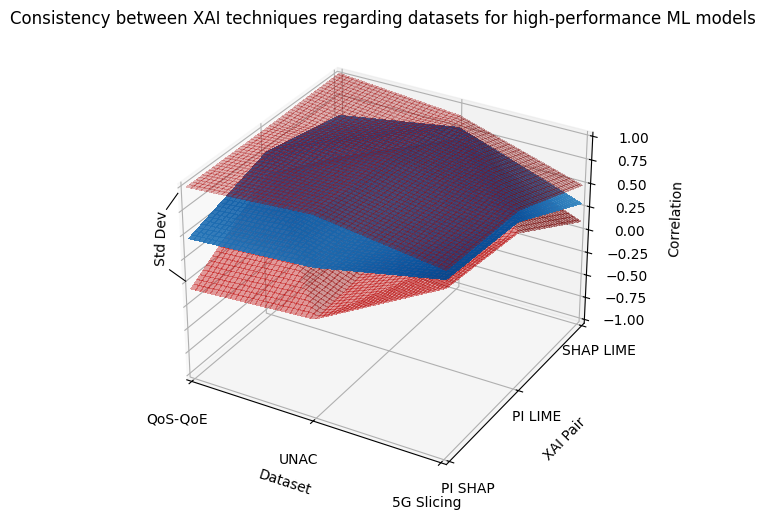

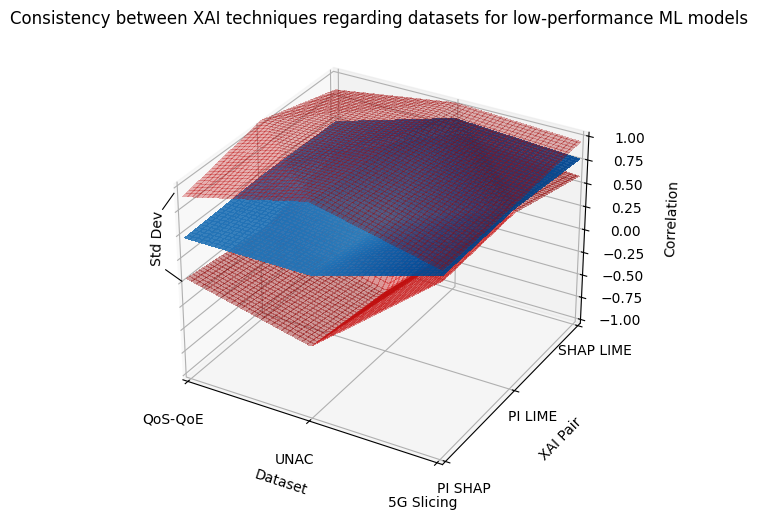

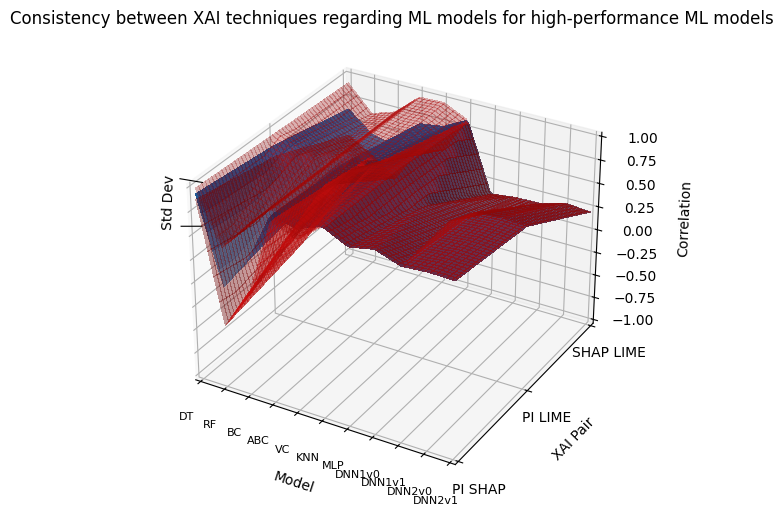

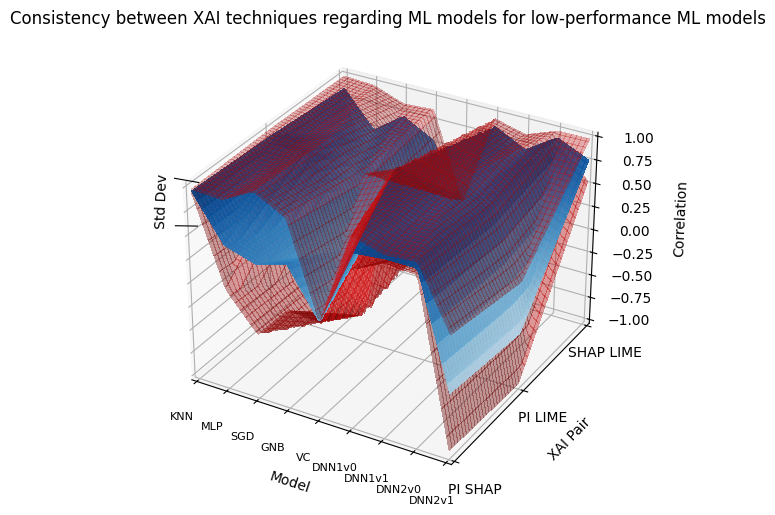

In [3]:
# plot consistency

plot_consistency_regarding_datasets()
plot_consistency_regarding_models()